"\nplt.figure()\nplt.plot(states.t, reaction_rate)\nplt.xlabel('Time [s]')\nplt.ylabel('Reaction rate of propane [mole/s]')\nplt.title('Reaction rate of propane')\nplt.figure()\nplt.plot(states.t, states.u)\nplt.xlabel('Time [s]')\nplt.ylabel('Internal energy [J/mole]')\nplt.title('Internal energy')\nplt.show()\n"

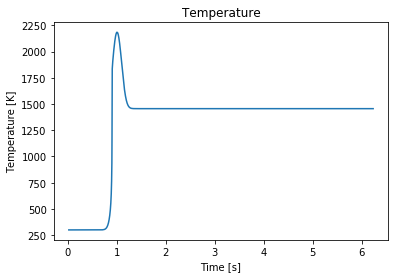

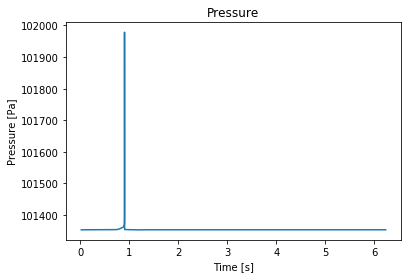

In [5]:
"""
A combustor. Two separate stream - one pure methane and the other air, both at
300 K and 1 atm flow into an adiabatic combustor where they mix and burn.

We are interested in the steady-state burning solution. Since at 300 K no
reaction will occur between methane and air, we need to use an 'igniter' to
initiate the chemistry. A simple igniter is a pulsed flow of atomic hydrogen.
After the igniter is turned off, the system approaches the steady burning
solution.
"""

import math
import csv
import matplotlib.pyplot as plt
import cantera as ct

# use reaction mechanism GRI-Mech 3.0

gas = ct.Solution('gri30.xml')

# create a reservoir for the fuel inlet, and set to pure methane.
gas.TPX = 300.0, ct.one_atm, 'CH4:1.0'
fuel_in = ct.Reservoir(gas)
fuel_mw = gas.mean_molecular_weight

# use predefined function Air() for the air inlet
air = ct.Solution('air.xml')
air_in = ct.Reservoir(air)
air_mw = air.mean_molecular_weight

# to ignite the fuel/air mixture, we'll introduce a pulse of radicals. The
# steady-state behavior is independent of how we do this, so we'll just use a
# stream of pure atomic hydrogen.
gas.TPX = 300.0, ct.one_atm, 'H:1.0'
igniter = ct.Reservoir(gas)

# create the combustor, and fill it in initially with N2
gas.TPX = 300.0, ct.one_atm, 'N2:1.0'
combustor = ct.IdealGasReactor(gas)
combustor.volume = 1.0

# create a reservoir for the exhaust
exhaust = ct.Reservoir(gas)

# lean combustion, phi = 0.5
equiv_ratio = 0.5

# compute fuel and air mass flow rates
factor = 0.1
air_mdot = factor * 9.52 * air_mw
fuel_mdot = factor * equiv_ratio * fuel_mw

# create and install the mass flow controllers. Controllers m1 and m2 provide
# constant mass flow rates, and m3 provides a short Gaussian pulse only to
# ignite the mixture
m1 = ct.MassFlowController(fuel_in, combustor, mdot=fuel_mdot)

# note that this connects two reactors with different reaction mechanisms and
# different numbers of species. Downstream and upstream species are matched by
# name.
m2 = ct.MassFlowController(air_in, combustor, mdot=air_mdot)

# The igniter will use a Gaussian time-dependent mass flow rate.
fwhm = 0.2
amplitude = 0.1
t0 = 1.0
igniter_mdot = lambda t: amplitude * math.exp(-(t-t0)**2 * 4 * math.log(2) / fwhm**2)
m3 = ct.MassFlowController(igniter, combustor, mdot=igniter_mdot)

# put a valve on the exhaust line to regulate the pressure
v = ct.Valve(combustor, exhaust, K=1.0)

# the simulation only contains one reactor
sim = ct.ReactorNet([combustor])

# take single steps to 6 s, writing the results to a CSV file for later
# plotting.
tfinal = 6.0
tnow = 0.0
Tprev = combustor.T
tprev = tnow
states = ct.SolutionArray(gas, extra=['t','tres'])

while tnow < tfinal:
    tnow = sim.step()
    tres = combustor.mass/v.mdot(tnow)
    Tnow = combustor.T
    if abs(Tnow - Tprev) > 1.0 or tnow-tprev > 2e-2:
        tprev = tnow
        Tprev = Tnow
        states.append(gas.state, t=tnow, tres=tres)

states.write_csv('combustor.csv', cols=('t','T','tres','X'))


#matplotlib
plt.figure()
plt.plot(states.t, states.T)
plt.xlabel('Time [s]')
plt.ylabel('Temperature [K]')
plt.title('Temperature')
plt.figure()
plt.plot(states.t, states.P)
plt.xlabel('Time [s]')
plt.ylabel('Pressure [Pa]')
plt.title('Pressure')

"""
plt.figure()
plt.plot(states.t, reaction_rate)
plt.xlabel('Time [s]')
plt.ylabel('Reaction rate of propane [mole/s]')
plt.title('Reaction rate of propane')
plt.figure()
plt.plot(states.t, states.u)
plt.xlabel('Time [s]')
plt.ylabel('Internal energy [J/mole]')
plt.title('Internal energy')
plt.show()
"""